In [5]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from dataclasses import dataclass



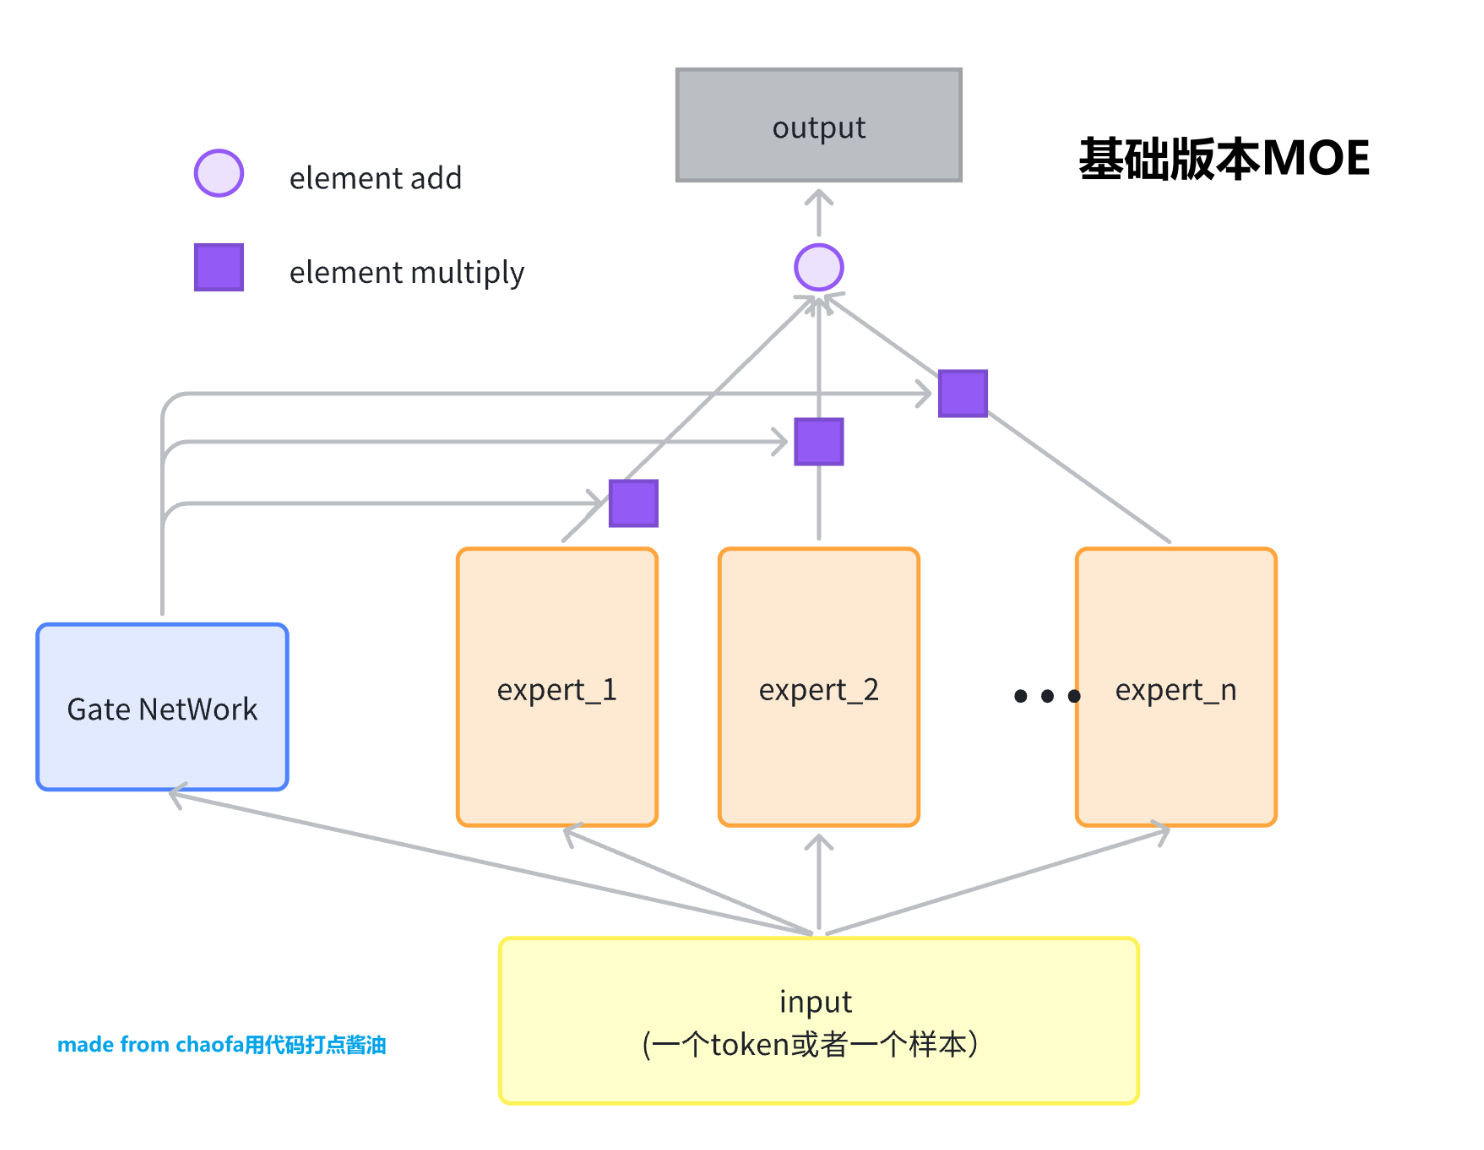

In [ ]:
from IPython.display import Image, display
display(Image(filename="../markdown/assets/basic_moe.png"))

In [14]:
# 基本的专家映射模型    选择了线性映射
class BaseExpert(nn.Module):
    def __init__(self, feature_in,feature_out):
        super().__init__()
        self.expert = nn.Linear(feature_in,feature_out)

    def forward(self,x):
        return self.expert(x)

class BaseMoe(nn.Module):
    def __init__(self,feature_in,feature_out,expert_num):
        super().__init__()
        # 循环迭代创建专家
        self.expert = nn.ModuleList([
            BaseExpert(feature_in,feature_out) for _ in range(expert_num)
        ]
        )

        # 每一个专家所占的权重
        self.gate = nn.Linear(feature_in,expert_num)

    def forward(self,x):
        # 创建专家的权重
        # shape(batch,expert_num)
        gate = self.gate(x)

        # 循环创建不同的专家 ps:torch.cat 和 torch.concat 相同，cat老版本先出现，兼容性高
        # 需要对创建的所有专家进行拼接，所以需要开创第二个维度，然后才可以拼接
        # experts -> (batch,feature_out)  to (batch,1,feature_out) to (batch,expert_num,feature_out)
        experts = torch.cat([
            experts(x).unsqueeze(1) for experts in self.expert],
            dim=1
        )
        # 对gate进行增加维度 才可以进行矩阵相乘
        # gate -> (batch,1,expert_num)
        gate = gate.unsqueeze(1)

        # 最终的输出为:(batch,feature_out)
        # 这里的output为(batch,1,feature_out) 需要再进行去除维度
        output = gate @ experts

        return output.squeeze(1)
    
def test_basic_moe():
    x = torch.rand(2, 4)

    basic_moe = BaseMoe(4, 3, 2)
    out = basic_moe(x)
    print(out)
    print(out.shape)


test_basic_moe()

tensor([[ 0.2597, -0.1203, -0.3357],
        [ 0.0238, -0.2921, -0.1952]], grad_fn=<SqueezeBackward1>)
torch.Size([2, 3])


## 2. Sparse Moe


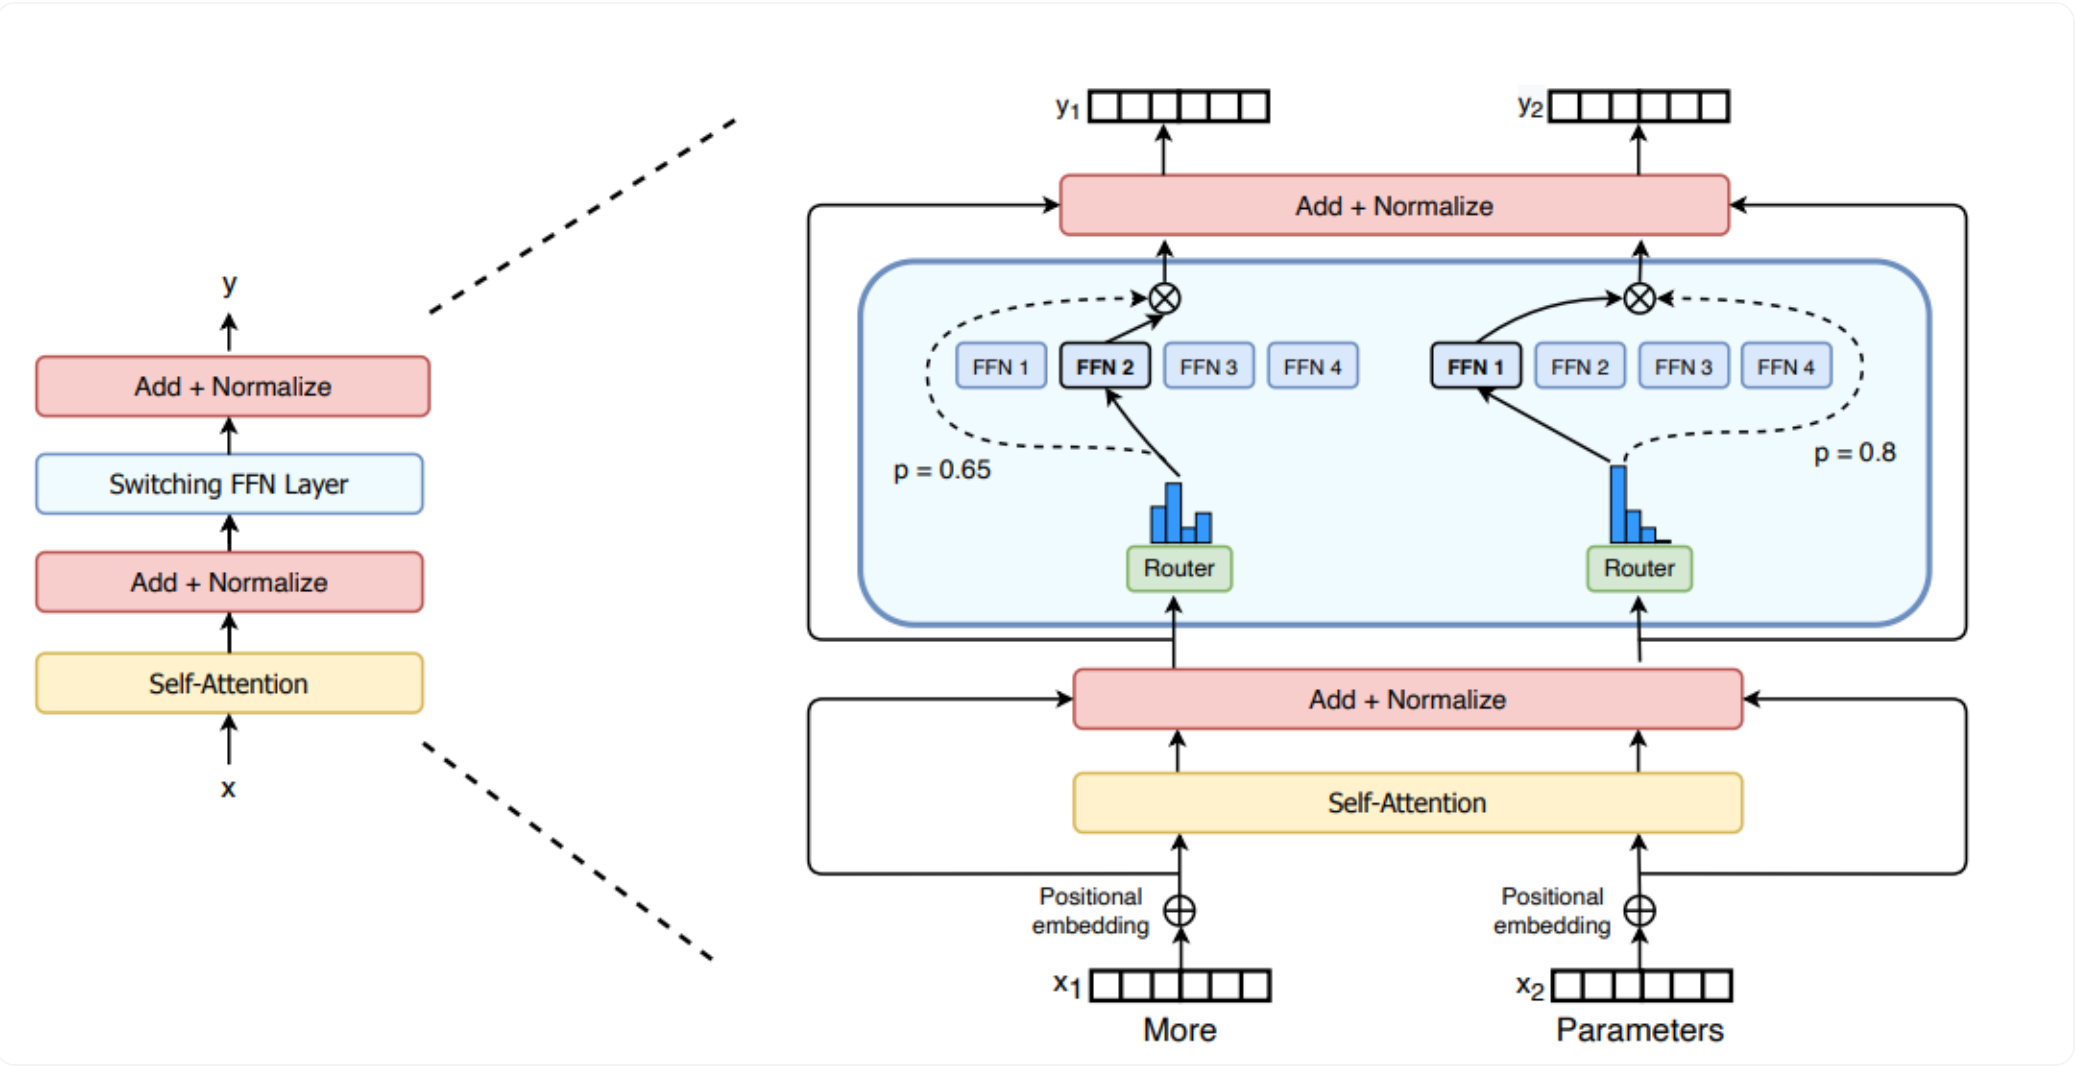

In [16]:
from IPython.display import Image, display
display(Image(filename="../markdown/assets/switch-transformers-moe-model.png"))

计算gate的topk,然后onehot topk,之后选择对应权重相乘

In [ ]:

class Moeconfig():
    def __init__(self,hidden_dim,expert_number,top_k,select_expert=None):
        self.hidden_dim = hidden_dim
        self.expert_number = expert_number
        self.top_k = top_k
        self.select_expert = select_expert
class RouterMoe(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        # 创建模型列表
        self.experts = nn.ModuleList([
            BaseMoe(config.hidden_dim,config.hidden_dim) for _ in range(config.expert_num)
        ])

        # 创建gate 获取概率
        self.gate = nn.Linear(config.hidden_dim,config.expert_num)
    
    def forward(self,x):
        # x shape(batch * seq , hidden_dim)
        gate = self.gate(x)

        # 计算概率 , 最后一个维度 shape(batch * seq, expert_num) 
        logists_gate = F.softmax(gate,dim=-1)
        
        # 选取最高概率的expert,输出的维度为(batch * seq , top_k)
        select_weight , select_mask = torch.topk(logists_gate,dim=-1,dtype=torch.float)
        
        # 对选取的权重进行归一化，保持维度不变
        select_weight = select_weight / select_weight.sum(dim=-1,keepdim=True)
        select_weight = select_weight.to(x.dtype)

        # 创建one hot , 总编码数量为 专家数量
        # shape (batch * seq , top_k , expert_num)
        one_hot_mask = F.one_hot(select_mask,self.config.expert_num)

        # 对该矩阵进行shape变换(expert_num,top_k, batch * seq)
        one_hot_mask = one_hot_mask.permute(2,1,0)
        
        return logists_gate,select_weight,select_mask,one_hot_mask



class SparseMoe(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.routemoe = nn.ModuleList(
            [
                BaseMoe(config) for _ in range(config.expert_num)
            ]
        )
        self.experts = nn.ModuleList([
            BaseMoe(config.hidden_dim,config.hidden_dim) for _ in range(config.expert_num)
        ])

    def forward(self,x):
        # 先要变换x shape，然后才能输入进router moe中
        batch , seq , hidden_dim = x.size()
        
        logistis,select_weight,select_mask,one_hot_mask = self.routemoe(x)

        # 创建一个和原矩阵相同的矩阵用于接收数据,需要注意指定device
        final = torch.zeros((batch,seq,hidden_dim),dtype=x.dtype,device=x.device)

        # 遍历每一个专家
        for expert in range(config.expert_num):
        



In [ ]:
test = torch.tensor([[0,1],
                    [4,3],
                    [5,4],
                    [0,0]])
print(test.shape)
test = test.reshape(2,-1)
print(test)
idx,topx = torch.where(test)
idx,topx

hot = torch.tensor([[1,0],[0,0]])

torch.Size([4, 2])
tensor([[0, 1, 4, 3],
        [5, 4, 0, 0]])


(tensor([0, 0, 0, 1, 1]), tensor([1, 2, 3, 0, 1]))

In [ ]:
import torch

routing_probs = torch.tensor([
    [0.1, 0.4, 0.3, 0.2],  # 第一个 token 的 4 个专家概率
    [0.2, 0.1, 0.5, 0.2],  # 第二个 token 的 4 个专家概率
])  # shape = (2, 4), 假设 batch_size * seq_len = 2, expert_number = 4
# (4,2)
top_k = 2

router_weights, selected_experts = torch.topk(routing_probs, top_k, dim=-1)

print("router_weights:\n", router_weights)
print("selected_experts:\n", selected_experts)
print(routing_probs.shape,selected_experts.shape)

mask = F.one_hot(selected_experts,4)

print("未反转的矩阵:# shape(batch * seq,topx,expert_num)\n",mask)
mask = mask.permute(2,1,0)

print("原始反转矩阵:# shape(expert_num,topx,batch * seq)\n",mask)
choose = mask[1]
print("第二个专家的矩阵:(topx,batch * seq)\n",choose)
idx, topx = torch.where(choose)
print(idx,topx)
#(2,2)

router_weights:
 tensor([[0.4000, 0.3000],
        [0.5000, 0.2000]])
selected_experts:
 tensor([[1, 2],
        [2, 0]])
torch.Size([2, 4]) torch.Size([2, 2])
未反转的矩阵:# shape(batch * seq,topx,expert_num)
 tensor([[[0, 1, 0, 0],
         [0, 0, 1, 0]],

        [[0, 0, 1, 0],
         [1, 0, 0, 0]]])
原始反转矩阵:# shape(expert_num,topx,batch * seq)
 tensor([[[0, 0],
         [0, 1]],

        [[1, 0],
         [0, 0]],

        [[0, 1],
         [1, 0]],

        [[0, 0],
         [0, 0]]])
第二个专家的矩阵:(topx,batch * seq)
 tensor([[1, 0],
        [0, 0]])
tensor([0]) tensor([0])


In [46]:
test = torch.tensor([1,2,3])
b = torch.tensor([2])
a = b*test
b.shape,test.shape,

(torch.Size([1]), torch.Size([3]))